In [1]:
%matplotlib inline

In [36]:
import re
import time
import json
from os import path
from collections import Counter

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import division, unicode_literals
from __future__ import print_function
from nltk.stem import *
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

In [8]:
stemmer = SnowballStemmer("english")

Using http://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html

In [3]:
campaign_str = "Obama_2012"
campaign_file = "../out/" + campaign_str + ".json"

with open(campaign_file, "r") as infile:
    campaign_data = json.load(infile)

### Aggregated speeches

In [27]:
all_speeches = ""

for title in campaign_data:
    #all_speeches += campaign_data[title]['speech']
    all_speeches += stemmer.stem(campaign_data[title]['speech'])

In [28]:
cv = CountVectorizer(min_df=0, stop_words="english", max_features=200)
counts = cv.fit_transform([all_speeches]).toarray().ravel()
scaled_counts = counts / float(counts.max())
words = np.array(cv.get_feature_names())

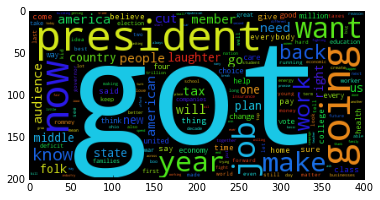

In [29]:
wordcloud = WordCloud().generate(all_speeches)
plt.imshow(wordcloud)

### Using NLTK

In [30]:
nltk_tokens = word_tokenize(all_speeches)

In [33]:
nouns = [token for token, pos in pos_tag(nltk_tokens) if pos.startswith('N')]

In [37]:
Counter(nouns)

Counter({u'i': 3542, u'president': 1902, u'years': 1286, u'jobs': 1253, u'audience': 1159, u'people': 1145, u'tax': 1088, u'america': 1064, u'country': 1004, u']': 945, u'members': 926, u'laughter': 919, u'plan': 910, u'folks': 823, u'everybody': 777, u'class': 762, u'states': 640, u'way': 625, u'economy': 615, u'romney': 588, u'home': 581, u'care': 575, u'health': 549, u'companies': 539, u'time': 535, u'election': 530, u'work': 522, u'world': 512, u'education': 500, u'choice': 486, u'families': 481, u'college': 479, u'americans': 474, u'money': 457, u'workers': 450, u'deficit': 443, u'change': 440, u'taxes': 417, u'war': 413, u'lot': 381, u'job': 380, u'kids': 375, u'energy': 373, u'governor': 365, u'cuts': 356, u'thing': 354, u'businesses': 345, u'vote': 340, u'insurance': 339, u'things': 332, u'matter': 329, u'reason': 309, u'term': 305, u'boo': 298, u'nation': 291, u'future': 282, u'today': 279, u'idea': 269, u'oil': 268, u'cut': 268, u'campaign': 262, u'bill': 257, u'family': 256,